In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as data

In [98]:
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

df = pdr.get_data_yahoo("^JKSE", start="2004-01-01", end="2024-05-17")
df.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-05-08,7129.456055,7164.308105,7071.345215,7088.794922,7088.794922,147871800
2024-05-13,7061.373047,7111.599121,7052.229980,7099.261230,7099.261230,134590500
2024-05-14,7095.521973,7136.640137,7071.501953,7083.763184,7083.763184,137468100
2024-05-15,7085.378906,7192.145020,7082.118164,7179.831055,7179.831055,139854300
2024-05-16,7203.169922,7270.756836,7201.915039,7246.695801,7246.695801,154713600


In [99]:
df = df.reset_index()
df = df.drop(['Date', 'Adj Close'], axis=1)
df.head()

,Open,High,Low,Close,Volume
0,691.375977,704.497986,687.997986,704.497986,11244500
1,706.369995,725.471985,706.369995,725.471985,35915500
2,728.719971,738.158997,717.828979,723.989014,39797000
3,723.906006,723.924011,705.841003,709.367004,33583800
4,709.362976,730.815002,709.362976,730.815002,31361400


In [100]:
df.shape

(4947, 5)

In [101]:
# Moving Average for 100
ma100 = df.Close.rolling(100).mean()

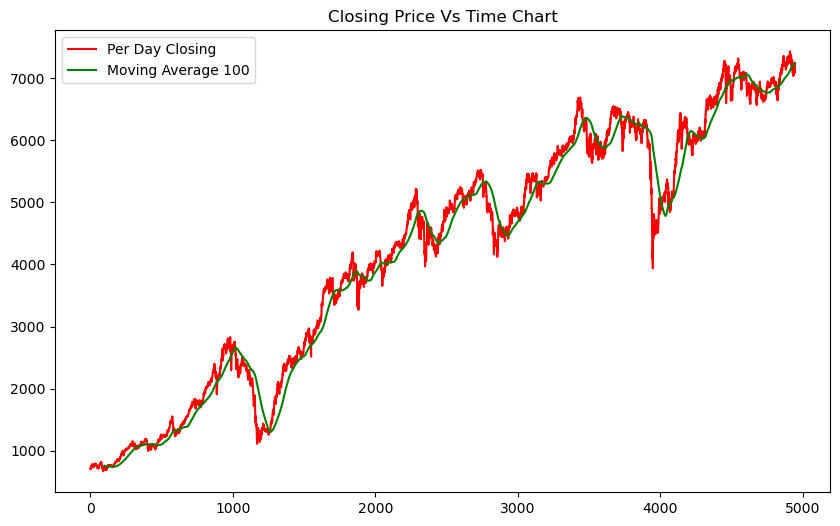

In [102]:
plt.figure(figsize = (10, 6))
plt.title("Closing Price Vs Time Chart")
plt.plot(df.Close, 'r', label="Per Day Closing")
plt.plot(ma100, 'g', label="Moving Average 100")
plt.legend()

In [103]:
# Moving Average for 200
ma200 = df.Close.rolling(200).mean()

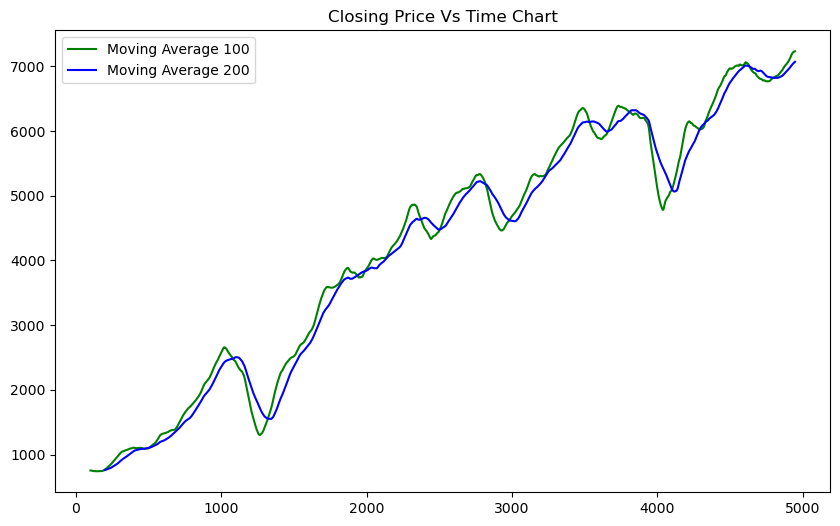

In [104]:
plt.figure(figsize = (10, 6))
plt.title("Closing Price Vs Time Chart")
plt.plot(ma100, 'g', label="Moving Average 100")
plt.plot(ma200, 'b', label="Moving Average 200")
plt.legend()

In [105]:
train_df = pd.DataFrame(df['Close'][0: int(len(df)*0.80)])
test_df = pd.DataFrame(df['Close'][int(len(df)*0.80):int(len(df))])
print(train_df.shape)
print(test_df.shape)

(3957, 1)
(990, 1)


In [106]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [107]:
train_df_arr = scaler.fit_transform(train_df)
train_df_arr

array([[0.00598275],
       [0.00946633],
       [0.00922003],
       ...,
       [0.64164257],
       [0.65688041],
       [0.68817154]])

In [108]:
x_train = []
y_train = []
for i in range(100, train_df_arr.shape[0]):
    x_train.append(train_df_arr[i-100: i])    
    y_train.append(train_df_arr[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape, y_train.shape

((3857, 100, 1), (3857,))

In [109]:
# 1. Dropout is a regularization technique where randomly selected neurons are ignored during training. 
# In order to prevent Neural Network from overfitting
# 2. LSTM, which stands for long short-term memory network, is a special kind of RNN that can perform 
# learning from long-term dependencies, which is a problem when using simple RNN.
# 3. A recurrent neural network (RNN) is a type of artificial neural network which uses sequential data or time series data.
# 4. A dense layer is a fully connected layer used in the neural network's end stages 
# to change the output's dimensionality from the preceding layer.
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

In [112]:
from keras.initializers import Orthogonal
initializer = Orthogonal(gain=1.0, seed=None)

model = Sequential()

model.add(LSTM(units=50, activation='relu', recurrent_initializer=Orthogonal(gain=1.0), return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=60, activation='relu', recurrent_initializer=Orthogonal(gain=1.0), return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=80, activation='relu', recurrent_initializer=Orthogonal(gain=1.0), return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units=120, activation='relu', recurrent_initializer=Orthogonal(gain=1.0)))
model.add(Dropout(0.5))

model.add(Dense(units=1))

In [113]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100, 50)           10400     
                                                                 
 dropout_4 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_5 (LSTM)               (None, 100, 60)           26640     
                                                                 
 dropout_5 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_6 (LSTM)               (None, 100, 80)           45120     
                                                                 
 dropout_6 (Dropout)         (None, 100, 80)           0         
                                                                 
 lstm_7 (LSTM)               (None, 120)              

In [115]:
from keras.callbacks import EarlyStopping

model.compile(loss='mean_squared_error', optimizer='adam')

# Define the early stopping criteria
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

model.fit(x_train, y_train, epochs=50, callbacks=[early_stop])

Epoch 1/50
121/121 [==============================] - 17s 119ms/step - loss: 0.0061
Epoch 2/50
121/121 [==============================] - 17s 137ms/step - loss: 0.0052
Epoch 3/50
121/121 [==============================] - 18s 147ms/step - loss: 0.0046
Epoch 4/50
121/121 [==============================] - 18s 150ms/step - loss: 0.0049
Epoch 5/50
121/121 [==============================] - 16s 131ms/step - loss: 0.0037
Epoch 6/50
121/121 [==============================] - 15s 128ms/step - loss: 0.0038
Epoch 7/50
121/121 [==============================] - 15s 127ms/step - loss: 0.0035
Epoch 8/50
121/121 [==============================] - 15s 127ms/step - loss: 0.0033
Epoch 9/50
121/121 [==============================] - 15s 128ms/step - loss: 0.0034
Epoch 10/50
121/121 [==============================] - 15s 128ms/step - loss: 0.0030
Epoch 11/50
121/121 [==============================] - 15s 128ms/step - loss: 0.0029
Epoch 12/50
121/121 [==============================] - 15s 127ms/step - lo

In [117]:
model.save('keras_model.h5')

In [118]:
past_100_days = train_df.tail(100)

In [119]:
final_df = past_100_days._append(test_df, ignore_index=True)
final_df.head()

,Close
0,6180.992188
1,6142.500977
2,6098.950195
3,6128.345215
4,6122.625000


In [120]:
input_data = scaler.fit_transform(final_df)
input_data

array([[0.64175161],
       [0.63074054],
       [0.61828209],
       ...,
       [0.90000473],
       [0.92748659],
       [0.9466144 ]])

In [121]:
input_data.shape

(1090, 1)

In [122]:
x_test = []
y_test = []
for i in range(100, input_data.shape[0]):
    x_test.append(input_data[i-100: i])    
    y_test.append(input_data[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test.shape, y_test.shape

((990, 100, 1), (990,))

In [123]:
y_pred = model.predict(x_test)
y_pred.shape

31/31 [==============================] - 2s 39ms/step


(990, 1)

In [124]:
scale = scaler.scale_
scale_factor = 1/scale
y_pred = y_pred*scale_factor
y_test = y_test*scale_factor

In [125]:
from sklearn.metrics import mean_squared_error
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Test RMSE: {test_rmse}')

Test RMSE: 165.97588566366935


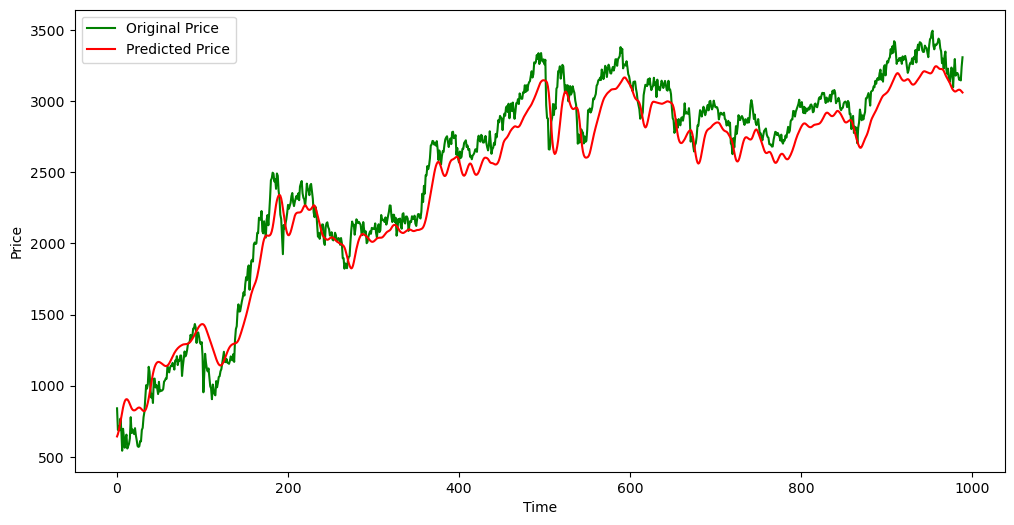

In [126]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, 'g', label="Original Price")
plt.plot(y_pred, 'r', label="Predicted Price")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

In [127]:
from keras.models import load_model
model = load_model('keras_model.h5')

In [128]:
scale = scaler.scale_
scale_factor = 1/scale

In [129]:
import numpy as np

def multistep_forecast(model, input_seq, n_steps):
    # input_seq is the last known data points (scaled), shape should be (100,) if using past 100 days
    forecast = input_seq[-100:].reshape(1, 100, 1)  # Reshape to (1, 100, 1) to match model's input shape
    predictions = []

    for _ in range(n_steps):
        # Predict the next step and scale it back
        pred = model.predict(forecast)[0, 0]  # assuming model.predict returns shape (1, 1, 1)
        predictions.append(pred * scale_factor)  # scale back the prediction
        
        # Update the forecast to include the new prediction
        new_forecast = np.append(forecast[0, 1:, 0], pred).reshape(1, 100, 1)
        forecast = new_forecast

    return predictions


In [130]:
# Using the last part of your input_data as the starting sequence
final_df = pdr.get_data_yahoo("^JKSE", start="2004-01-01", end="2024-05-17")
final_df = final_df.reset_index()
final_df = final_df.drop(['Date', 'Adj Close'], axis=1)
final_df = pd.DataFrame(final_df['Close'])
input_data = scaler.fit_transform(final_df)
scale = scaler.scale_
scale_factor = 1/scale

last_known_points = input_data[-100:]
predictions_10_days = multistep_forecast(model, last_known_points, 10)
print("10-day forecast:", predictions_10_days)

[*********************100%%**********************]  1 of 1 completed
1/1 [==============================] - 0s 32ms/step
10-day forecast: [array([6154.66847247]), array([6151.02904699]), array([6137.02455711]), array([6110.81553251]), array([6074.30353873]), array([6031.18445146]), array([5985.28841722]), array([5939.94801431]), array([5896.93940816]), array([5856.89443787])]


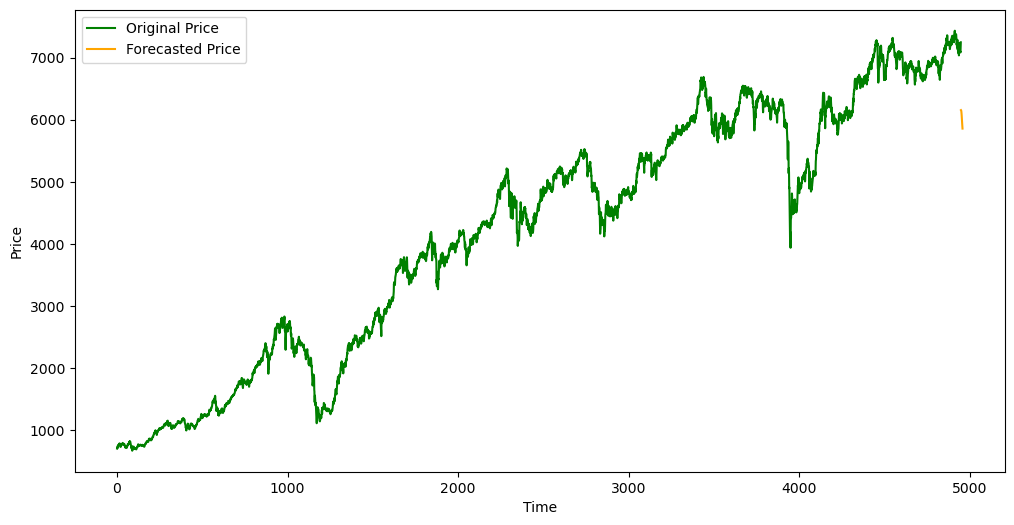

In [131]:
# plot 10 days forecast
plt.figure(figsize=(12, 6))
plt.plot(final_df, 'g', label="Original Price")
plt.plot(range(len(final_df), len(final_df) + len(predictions_10_days)), predictions_10_days, 'orange', label="Forecasted Price")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

In [132]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from pandas_datareader import data as pdr

def multistep_forecast_with_confidence(model, scaler, input_seq, n_steps, confidence_pct=0.05):
    # Reshape input to match the model's expected input shape
    forecast = input_seq[-100:].reshape(1, 100, 1)
    predictions = []
    lower_bounds = []
    upper_bounds = []

    for _ in range(n_steps):
        pred = model.predict(forecast)[0, 0]
        # Inverse transform the scaled prediction
        pred_rescaled = scaler.inverse_transform([[pred*1.05]])[0, 0]
        predictions.append(pred_rescaled)
        
        # Calculate confidence interval bounds
        lower_bound = pred_rescaled * (1 - confidence_pct)
        upper_bound = pred_rescaled * (1 + confidence_pct)
        lower_bounds.append(lower_bound)
        upper_bounds.append(upper_bound)
        
        # Update the forecast with the new prediction
        new_forecast = np.append(forecast[0, 1:, 0], pred).reshape(1, 100, 1)
        forecast = new_forecast

    return predictions, lower_bounds, upper_bounds

# Fetch new data and preprocess it
final_df = pdr.get_data_yahoo("^JKSE", start="2004-01-01", end="2024-05-17")
final_df = final_df.reset_index()
final_df = final_df.drop(['Date', 'Adj Close'], axis=1)
final_df = pd.DataFrame(final_df['Close'])

# Scaling data
scaler = MinMaxScaler(feature_range=(0, 1))
input_data = scaler.fit_transform(final_df)

# Prepare the last known data points
last_known_points = input_data[-100:]

# Forecasting the next 10 days with confidence intervals
predictions_10_days, lower_bounds, upper_bounds = multistep_forecast_with_confidence(model, scaler, last_known_points, 10)
print("10-day forecast:", predictions_10_days)
print("Lower bounds:", lower_bounds)
print("Upper bounds:", upper_bounds)


[*********************100%%**********************]  1 of 1 completed
1/1 [==============================] - 0s 47ms/step
10-day forecast: [7130.878885835051, 7127.057489083692, 7112.352774706532, 7084.8332988768825, 7046.4957054103215, 7001.220663775383, 6953.029827832155, 6905.422404776515, 6860.263368316612, 6818.2161495082155]
Lower bounds: [6774.334941543298, 6770.704614629508, 6756.735135971205, 6730.591633933038, 6694.170920139805, 6651.159630586614, 6605.378336440547, 6560.151284537688, 6517.250199900782, 6477.305342032804]
Upper bounds: [7487.422830126804, 7483.410363537877, 7467.970413441859, 7439.074963820727, 7398.820490680838, 7351.281696964153, 7300.681319223763, 7250.693525015341, 7203.276536732443, 7159.126956983627]


In [133]:
final_df.tail()

,Close
4942,7088.794922
4943,7099.261230
4944,7083.763184
4945,7179.831055
4946,7246.695801


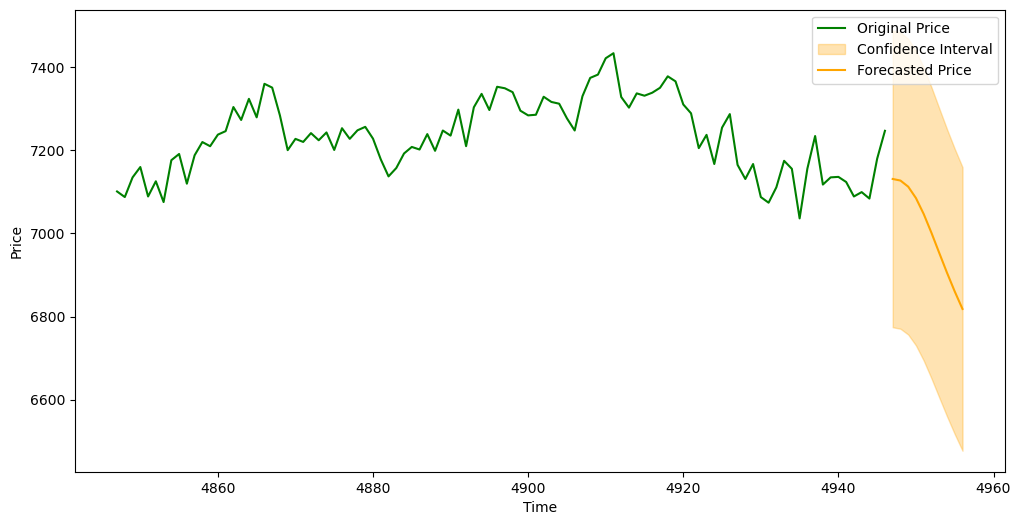

In [134]:
# plot 10 days forecast with the confidence interval
plt.figure(figsize=(12, 6))
plt.plot(final_df[-100:], 'g', label="Original Price")
plt.fill_between(range(len(final_df), len(final_df) + len(predictions_10_days)), lower_bounds, upper_bounds, color='orange', alpha=0.3, label="Confidence Interval")
plt.plot(range(len(final_df), len(final_df) + len(predictions_10_days)), predictions_10_days, 'orange', label="Forecasted Price")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()